# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
from maskmm.ipstartup import *
import os
import sys
import logging
import random
import numpy as np

from maskmm.datagen.rpn_targets import build_rpn_targets_batch
from maskmm.models.maskrcnn import MaskRCNN
from maskmm.utils import box_utils, image_utils, visualize
from maskmm.datagen.anchors import generate_pyramid_anchors

ROOT_DIR = "/home/ubuntu/maskmm"
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "data/models/mask_rcnn_coco.pth")
DATA = join(expanduser("~"), "data", "nuke") 

[maskmm.ipstartup:INFO]:running ipstartup (ipstartup.py:13, time=17:55)


## Dataset

In [2]:
from maskmm.nuke.dataset import Dataset
from maskmm.nuke.config import Config
config = Config()

# Load dataset
dataset = Dataset(config)
dataset.load_nuke(DATA, "stage1_train")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
model = MaskRCNN(config, MODEL_DIR)

[root:INFO]:starting (cellevents.py:36, time=17:55)


Image Count: 628
Class Count: 2
  0. BG                                                
  1. cell                                              
time: 101 ms


## Images and masks

[root:INFO]:starting (cellevents.py:36, time=16:26)


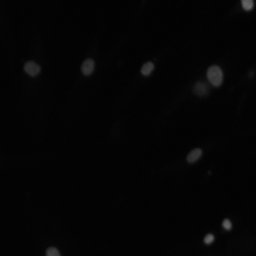

time: 39.2 ms


In [4]:
from PIL import Image
image = dataset.load_image(2)
Image.fromarray(image)

[root:INFO]:starting (cellevents.py:36, time=16:26)


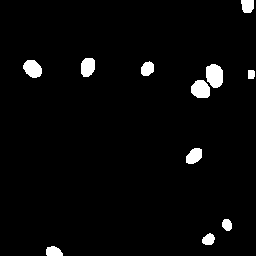

time: 12.4 ms


In [5]:
mask, classes = dataset.load_mask(2)
allmasks = np.max(mask, axis=2)
Image.fromarray(allmasks)

[root:INFO]:starting (cellevents.py:36, time=16:26)


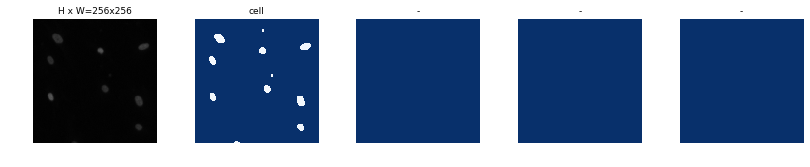

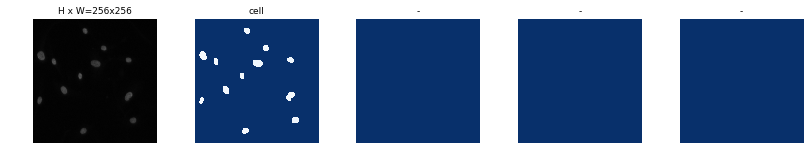

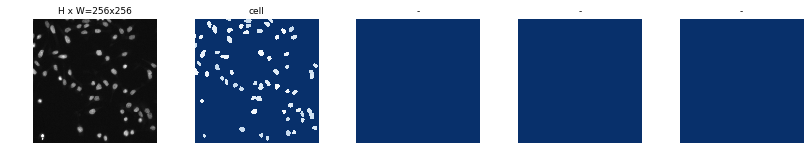

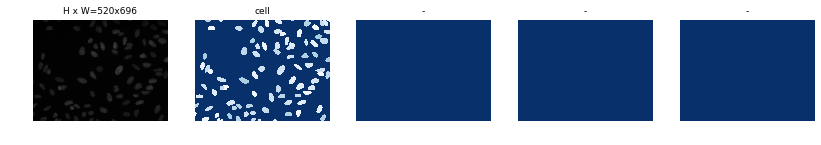

time: 2.65 s


In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

[root:INFO]:starting (cellevents.py:36, time=16:26)


image_id  129 


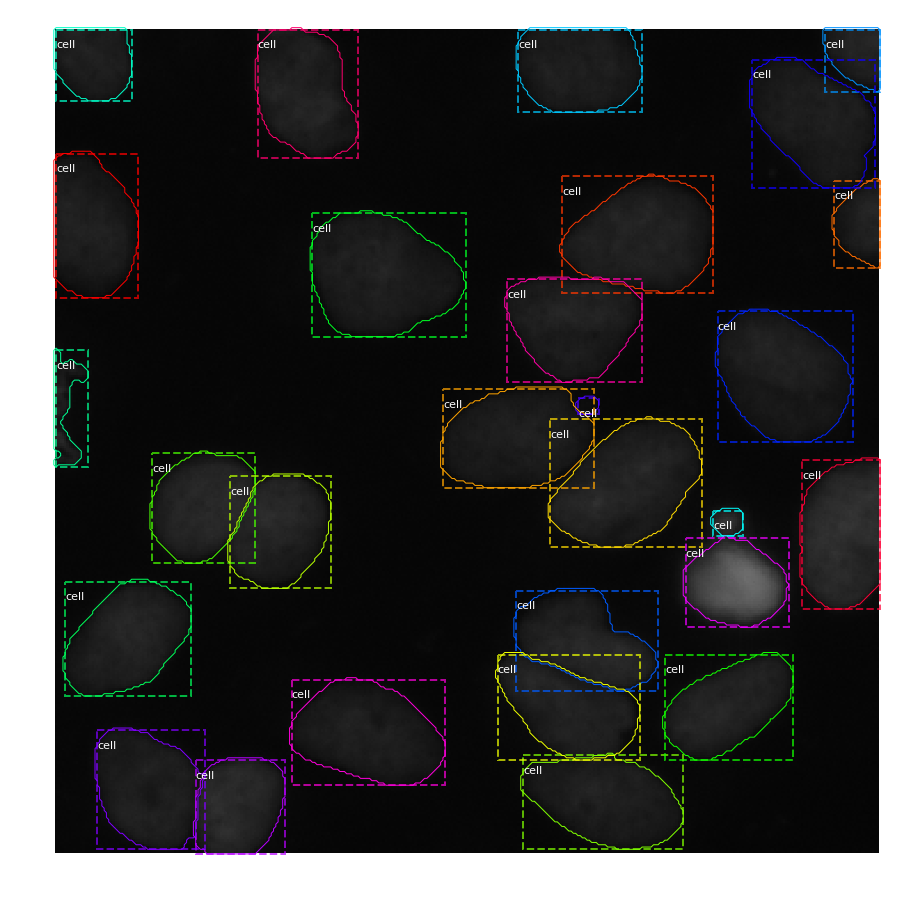

time: 1.05 s


In [7]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = box_utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

In [8]:
mask.shape

[root:INFO]:starting (cellevents.py:36, time=16:26)


(360, 360, 28)

time: 2.35 ms


[root:INFO]:starting (cellevents.py:36, time=16:27)
[maskmm.ipstartup:INFO]:('image_id: ', 129, '') (<ipython-input-10-187cfd8c3a11>:17, time=16:27)
[maskmm.ipstartup:INFO]:('Original shape: ', (360, 360, 4)) (<ipython-input-10-187cfd8c3a11>:18, time=16:27)
[maskmm.ipstartup:INFO]:('image', (1024, 1024, 4)) (<ipython-input-10-187cfd8c3a11>:19, time=16:27)
[maskmm.ipstartup:INFO]:('mask', (1024, 1024, 28)) (<ipython-input-10-187cfd8c3a11>:20, time=16:27)
[maskmm.ipstartup:INFO]:('class_ids', (28,)) (<ipython-input-10-187cfd8c3a11>:21, time=16:27)
[maskmm.ipstartup:INFO]:('bbox', (28, 4)) (<ipython-input-10-187cfd8c3a11>:22, time=16:27)


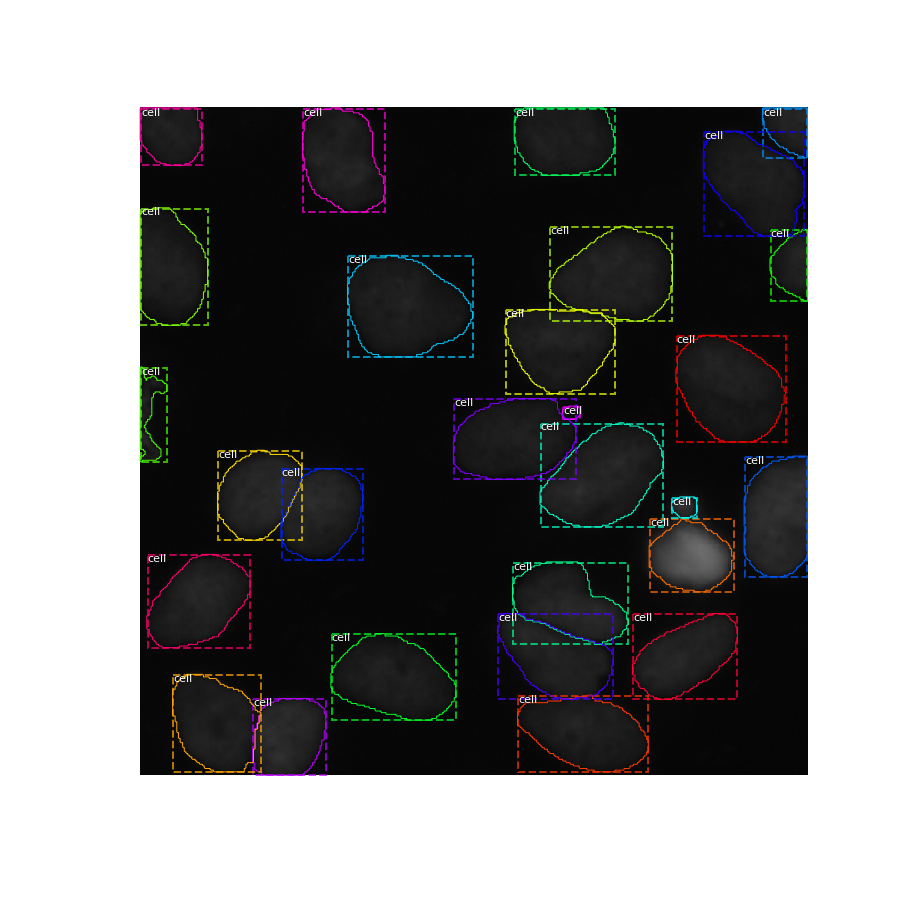

time: 2.72 s


In [10]:
# Load random image and mask.
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding = image_utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
mask = image_utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = box_utils.extract_bboxes(mask)

# Display image and additional stats
log.info(("image_id: ", image_id, dataset.image_reference(image_id)))
log.info(("Original shape: ", original_shape))
log.info(("image", image.shape))
log.info(("mask", mask.shape))
log.info(("class_ids", class_ids.shape))
log.info(("bbox", bbox.shape))
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

[root:INFO]:starting (cellevents.py:36, time=17:55)


136


'image'

(1024, 1024, 3)

'image_meta'

array([ 136,  520,  696,    3,  129,    0,  894, 1024,    1,    1])

'class_ids'

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

'bbox'

array([[ 800,  257,  827,  312],
       [ 295,  715,  339,  756],
       [ 859,  750,  894,  790],
       [ 828,    0,  863,   41],
       [ 129,  168,  141,  206],
       [ 869,  422,  894,  474],
       [ 676,  275,  713,  324],
       [ 453,  871,  485,  930],
       [ 804,  644,  874,  684],
       [ 282,  909,  291,  921],
       [ 500,  965,  541, 1017],
       [ 744,  783,  791,  828],
       [ 161,  879,  213,  917],
       [ 417,  213,  461,  257],
       [ 305,  597,  348,  637],
       [ 129,  951,  188,  987],
       [ 554,  612,  601,  664],
       [ 669,  904,  737,  961],
       [ 810,  559,  860,  602],
       [ 389,  655,  445,  697],
       [ 361,  964,  425, 1012],
       [ 709,  268,  746,  335],
       [ 194,   87,  233,  135],
       [ 519,  190,  550,  229],
       [ 559,  299,  600,  356],
       [ 740,  275,  771,  310],
       [ 741,  452,  788,  503],
       [ 704,   20,  738,   91],
       [ 373,  293,  419,  337],
       [ 713,  490,  751,  541],
       [ 7

'mask'

(1024, 1024, 141)

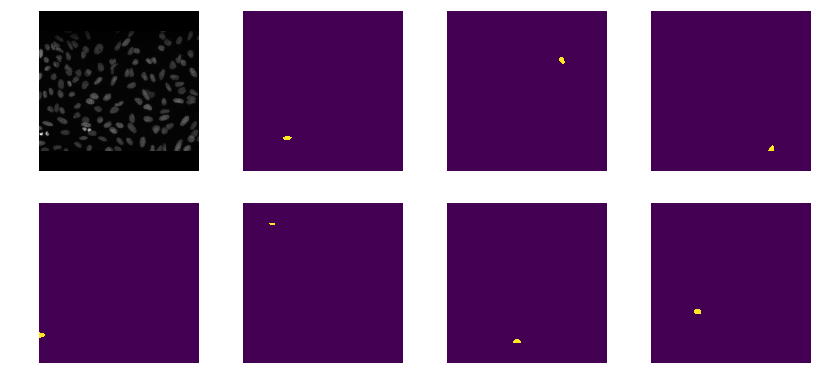

time: 6.8 s


In [3]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
print(image_id)
image, image_meta, class_ids, bbox, mask = dataset.load_image_gt(
                        image_id, use_mini_mask=False)

d("image", image.shape)
d("image_meta", image_meta)
d("class_ids", class_ids)
d("bbox", bbox)
d("mask", mask.shape)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

[root:INFO]:starting (cellevents.py:36, time=17:00)


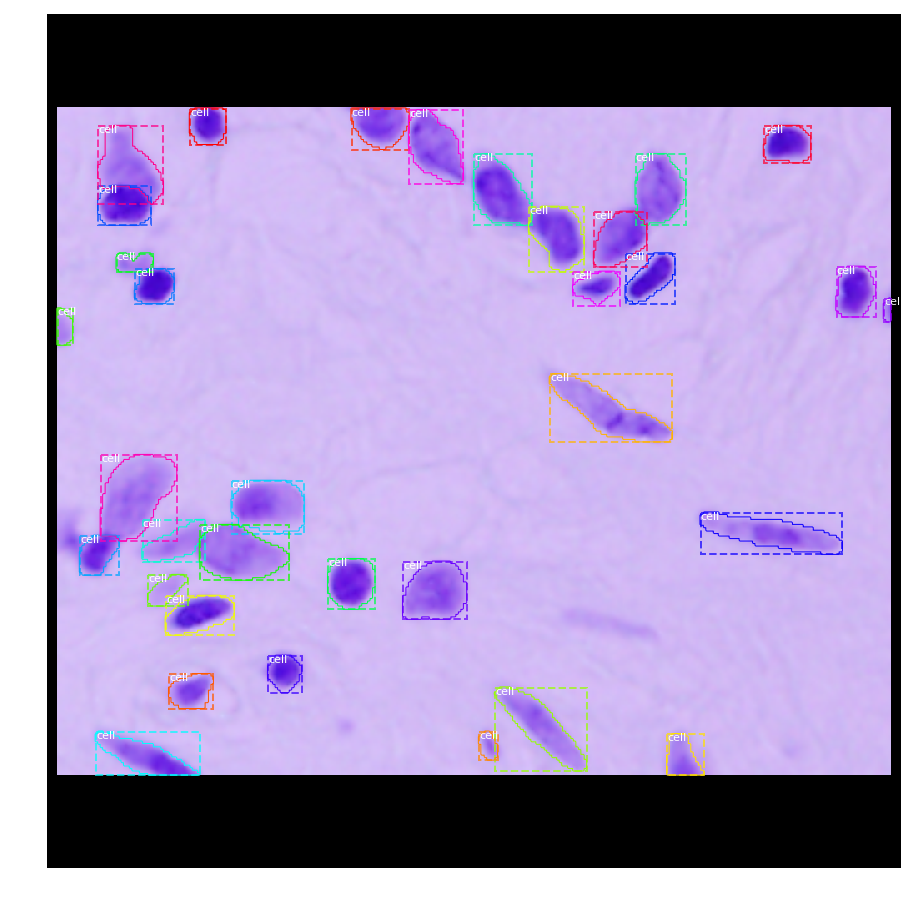

time: 3.12 s


In [30]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

[root:INFO]:starting (cellevents.py:36, time=17:00)


'mask'

(56, 56, 34)

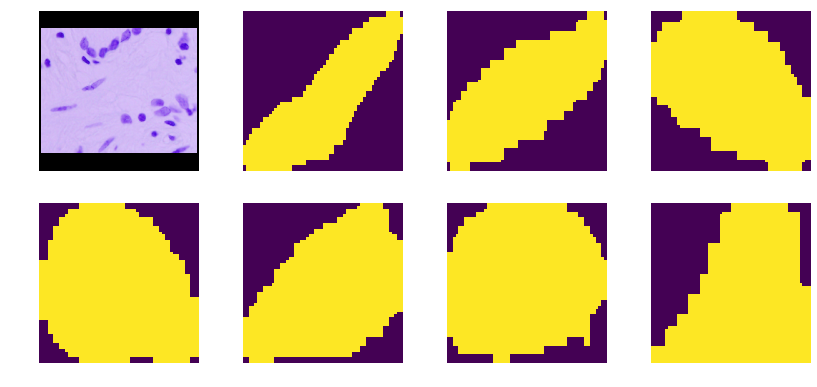

time: 1.72 s


In [31]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = dataset.load_image_gt(
                image_id, use_mini_mask=True)
d("mask", mask.shape)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

[root:INFO]:starting (cellevents.py:36, time=17:00)


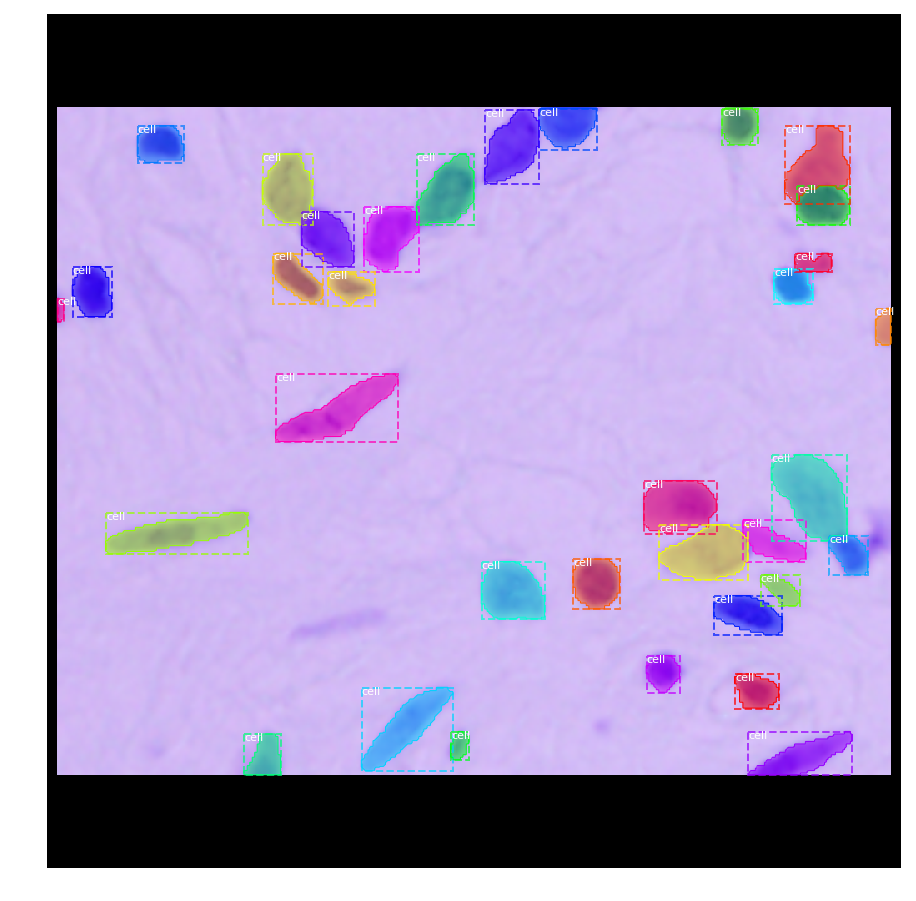

time: 3.05 s


In [32]:
mask = image_utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [33]:
# Generate Anchors
anchors = generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                  config.RPN_ANCHOR_RATIOS,
                                  config.BACKBONE_SHAPES,
                                  config.BACKBONE_STRIDES, 
                                  config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

[root:INFO]:starting (cellevents.py:36, time=17:00)


Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768
time: 30.1 ms


Visualize anchors of one cell at the center of the feature map of a specific level.

[root:INFO]:starting (cellevents.py:36, time=17:00)


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


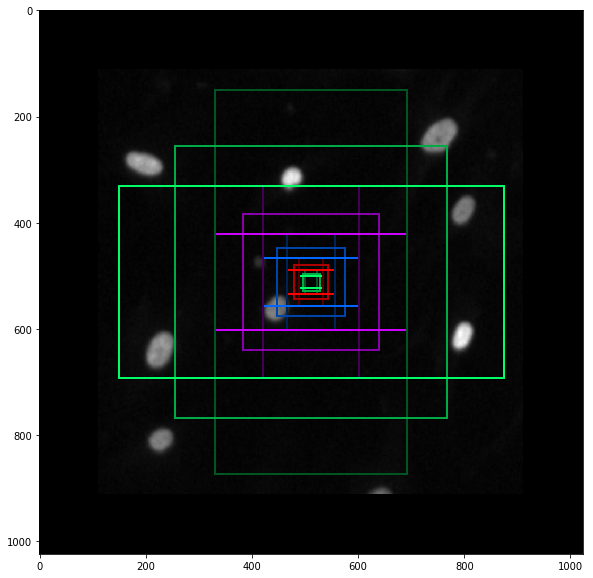

time: 953 ms


In [34]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = dataset.load_image_gt(image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [87]:
# Create data generator
random_rois = 2000
g = iter(torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4))
inputs = next(g)

[root:INFO]:starting (cellevents.py:36, time=19:36)


'g = modellib.data_generator(\n    dataset, config, shuffle=True, random_rois=random_rois, \n    batch_size=4,\n    detection_targets=True)'

time: 131 ms


In [148]:
# images and ground truth
images, image_metas, gt_class_ids, gt_boxes, gt_masks = inputs
if config.GPU_COUNT:
    images = images.cuda()
    gt_class_ids = gt_class_ids.cuda()
    gt_boxes = gt_boxes.cuda()
    gt_masks = gt_masks.cuda()
    
d(f"images {images.shape}")
d(f"image_metas {image_metas}")
d(f"gt_class_ids {gt_class_ids.shape}")
d(f"gt_boxes {gt_boxes.shape}")
d(f"gt_masks {gt_masks.shape}")

[root:INFO]:starting (cellevents.py:36, time=20:43)


'images torch.Size([1, 3, 1024, 1024])'

'image_metas tensor([[481, 256, 256,   3, 112, 112, 912, 912,   1,   1]])'

'gt_class_ids torch.Size([1, 12])'

'gt_boxes torch.Size([1, 12, 4])'

'gt_masks torch.Size([1, 12, 56, 56])'

time: 1.19 s


In [149]:
# rpn targets
rpn_match, rpn_bbox = build_rpn_targets_batch(model.anchors, gt_class_ids,
                                        gt_boxes, config)
if config.GPU_COUNT:
    rpn_match = rpn_match.cuda()
    rpn_bbox=rpn_bbox.cuda()
d(f"rpn_match {rpn_match.shape}")
d(f"rpn_bbox {rpn_bbox.shape}")

[root:INFO]:starting (cellevents.py:36, time=20:44)


'rpn_match torch.Size([1, 261888, 1])'

'rpn_bbox torch.Size([1, 22, 4])'

time: 55.4 ms


## positive, negative and neutral anchors

[root:INFO]:starting (cellevents.py:36, time=20:19)


'anchors'

torch.Size([261888, 4])

'refined_anchors'

torch.Size([128, 4])

Positive anchors: 128
Negative anchors: 128
Neutral anchors: 261632
cell                   : 100


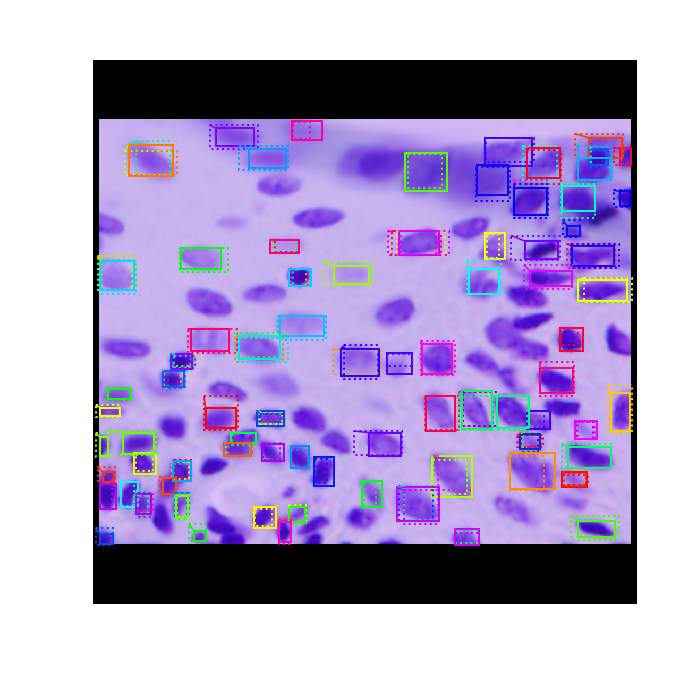

time: 1.7 s


In [136]:
b = 0

# Restore original image (reverse normalization)
sample_image = image_utils.unmold_image(images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = box_utils.apply_box_deltas(model.anchors[indices],
                                rpn_bbox[b, :len(indices)] \
                                * torch.tensor(config.RPN_BBOX_STD_DEV).type(rpn_bbox.type()))
d("anchors", model.anchors.shape)
d("refined_anchors", refined_anchors.shape)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(gt_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
boxes=model.anchors[positive_anchor_ids].cpu().numpy()
refined_anchors = refined_anchors.cpu().numpy()
visualize.draw_boxes(sample_image, boxes=boxes, refined_boxes=refined_anchors)

[root:INFO]:starting (cellevents.py:36, time=20:22)


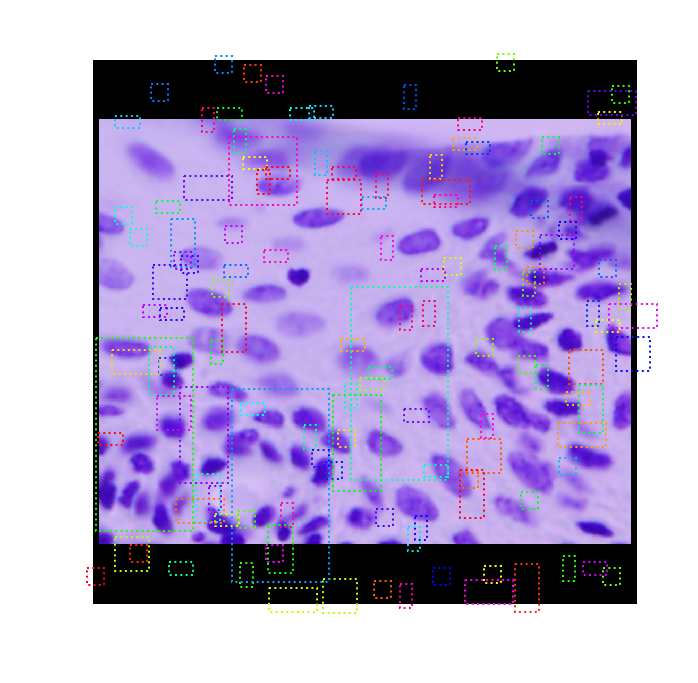

time: 1.18 s


In [139]:
# Show negative anchors
boxes=model.anchors[negative_anchor_ids].cpu().numpy()
visualize.draw_boxes(sample_image, boxes=boxes)

[root:INFO]:starting (cellevents.py:36, time=20:24)


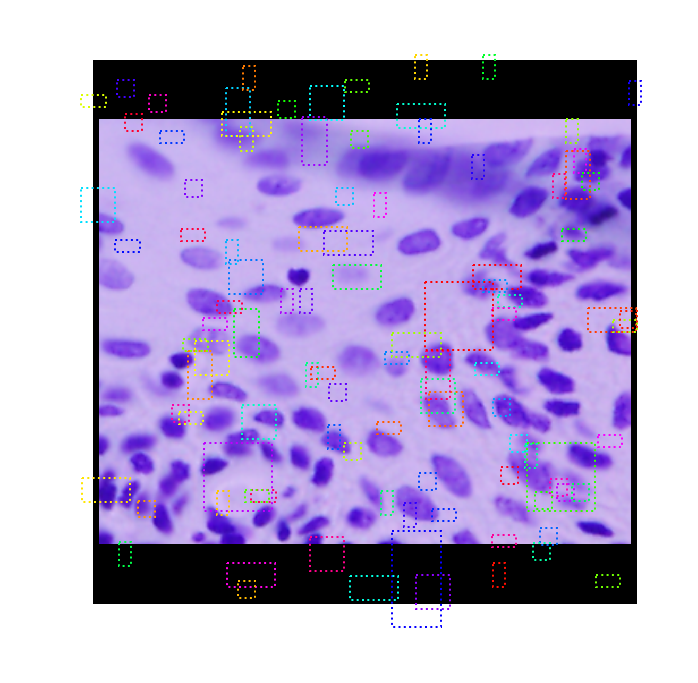

time: 1.14 s


In [141]:
# Show neutral anchors. They don't contribute to training.
boxes=model.anchors[np.random.choice(neutral_anchor_ids, 100)].cpu().numpy()
visualize.draw_boxes(sample_image, boxes=boxes)

## ROIs

In [144]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = box_utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

[root:INFO]:starting (cellevents.py:36, time=20:38)


NameError: name 'mrcnn_bbox' is not defined

time: 8.44 ms


In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [150]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

[root:INFO]:starting (cellevents.py:36, time=20:56)


NameError: name 'modellib' is not defined

time: 7.77 ms
